In [3]:
# ref: https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html
# ref: https://arxiv.org/abs/1511.04497

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["text.usetex"] = False
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["font.family"] = ["sans-serif"]
rcParams['font.sans-serif'] = ['cmss10']
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.stats import LombScargle
from astropy import constants, units

import pymc3 as pm
import pymc3.distributions.transforms as tr

import theano
import theano.tensor as tt

import exoplanet
from exoplanet import distributions

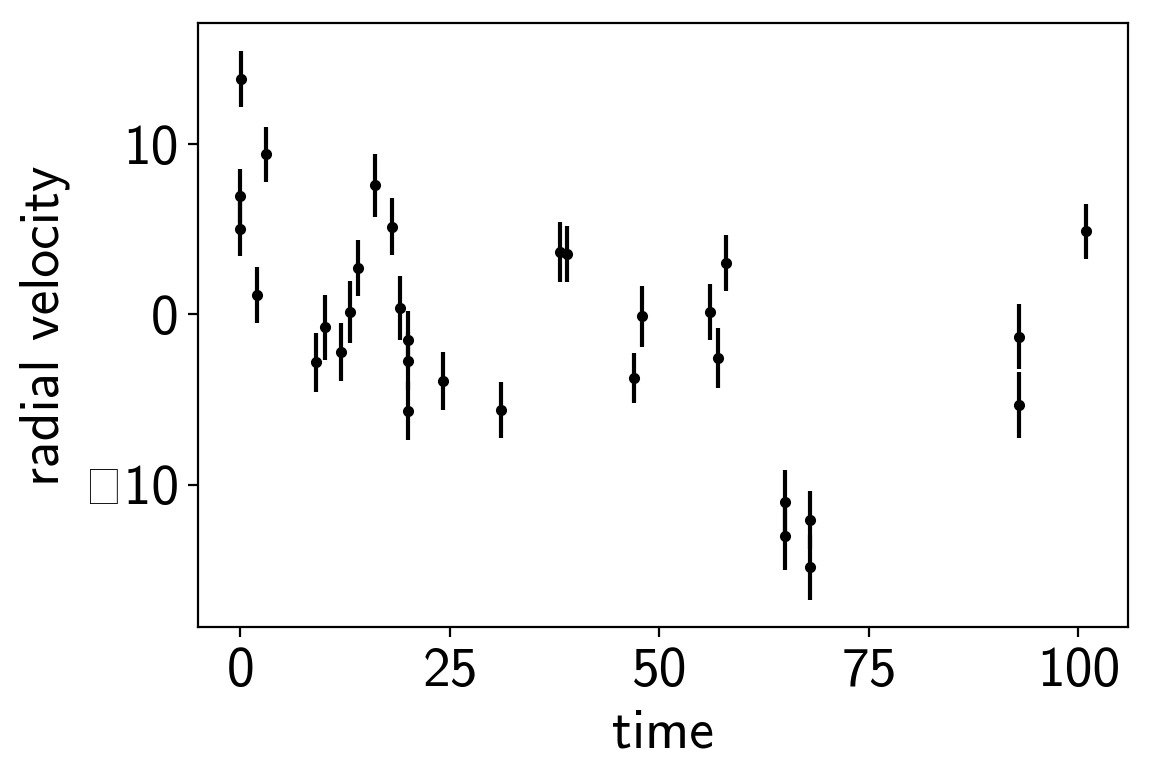

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv", index_col=0)

x_ref = np.min(data.t)
x = np.array(data.t - x_ref)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")

plt.xlabel("time")
plt.ylabel("radial velocity");

In [57]:
mass_conv = (constants.M_earth / constants.M_sun).value
rv_conv = (1 * units.R_sun / units.day).to(units.m / units.s).value

In [70]:
N_planets = 2

x_grid = np.linspace(x.min(), x.max(), 1000)

with pm.Model() as model:
    
    mstar = pm.Bound(pm.Normal, lower=0.0)("mstar", mu=1.12, sd=0.05)
    rstar = pm.Bound(pm.Normal, lower=0.0)("rstar", mu=1.21, sd=0.11)
    
    logjitter2 = pm.Normal("logjitter2", mu=np.log(0.05), sd=5.0)
    
    # Transit parameters from: https://arxiv.org/abs/1511.04497
    t0_mu = np.array([2072.7948, 2082.6251]) - x_ref
    t0_sd = np.array([0.0007, 0.0004])
    t0 = pm.Normal("t0", mu=t0_mu, sd=t0_sd, shape=N_planets)
    
    period_mu = np.array([20.8851, 42.3633])
    period_sd = np.array([0.0003, 0.0006])
    period = pm.Normal(
        "period", mu=period_mu, sd=period_sd,
        shape=N_planets)
    
    m_guess = np.array([23.2, 31.0])
    logm = pm.Uniform(
        "logm",
        lower=np.log(10.0),
        upper=np.log(50.0),
        shape=N_planets, testval=np.log(m_guess))

    ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, shape=N_planets,
                  testval=np.array([0.1, 0.1]))
    omega = distributions.Angle("omega", shape=N_planets)
    
    v0 = pm.Normal("v0", mu=0.0, sd=1.0)
    dvdt = pm.Normal("dvdt", mu=0.0, sd=0.1)
    d2vdt2 = pm.Normal("d2vdt2", mu=0.0, sd=0.01)
    
#     k = pm.Deterministic("k", tt.exp(logk))
    m = pm.Deterministic("m", tt.exp(logm))
    
    # The keplerian orbit
    orbit = exoplanet.orbits.KeplerianOrbit(
        period=period,
        t0=t0,
        ecc=ecc,
        omega=omega,
        # Convert Earth masses to Solar masses
        m_planet=m * (constants.M_earth / constants.M_sun).value,
        r_star=rstar,
        m_star=mstar,
    )
    
#     vrad = tt.sum(k * orbit._get_velocity(1.0, x)[2], axis=-1)

    # Convert R_sun / day to m / s
    rv_conv = (1 * units.R_sun / units.day).to(units.m / units.s).value
    vrad = rv_conv * tt.sum(orbit.get_star_velocity(x)[2], axis=-1)
    
    # background
    bkg = v0 + dvdt * x + d2vdt2 * x**2
    
    pm.Normal("obs", mu=vrad + bkg, sd=tt.sqrt(yerr**2 + tt.exp(logjitter2)), observed=y)
    
#     pm.Deterministic("vrad", k * orbit._get_velocity(1.0, x_grid)[2])
    pm.Deterministic("vrad", rv_conv * orbit.get_star_velocity(x_grid)[2])
    pm.Deterministic("bkg", v0 + dvdt * x_grid + d2vdt2 * x_grid**2)

    soln = pm.find_MAP(start=model.test_point)

logp = -47.073, ||grad|| = 3.1301: 100%|██████████| 2588/2588 [00:01<00:00, 1807.97it/s] 


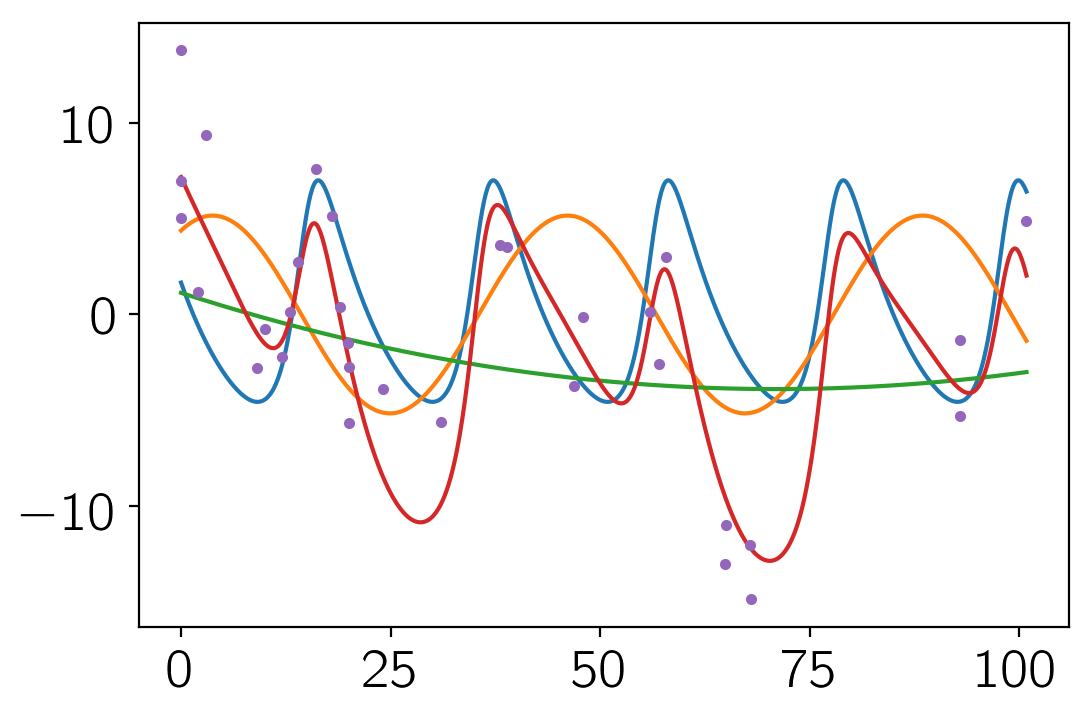

In [73]:
with model:
    plt.plot(x_grid, soln["vrad"])
    plt.plot(x_grid, soln["bkg"])
    plt.plot(x_grid, np.sum(soln["vrad"], axis=-1) + soln["bkg"])
    plt.plot(x, y, ".")

In [74]:
schedule = exoplanet.sampling.TuningSchedule()

with model:
    burnin = schedule.tune()

Only 2 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d2vdt2, dvdt, v0, omega, ecc, logm, period, t0, logjitter2, rstar, mstar]
Sampling 2 chains: 100%|██████████| 154/154 [00:05<00:00, 29.20draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only 2 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d2vdt2, dvdt, v0, omega, ecc, logm, period, t0, logjitter2, rstar, mstar]
Sampling 2 chains: 100%|██████████| 54/54 [00:02<00:00, 26.64draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only 2 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d2vdt2, dvdt, v0, omega, ecc, logm, period, t0, logji

In [83]:
with model:
    trace = schedule.sample(draws=2000)

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d2vdt2, dvdt, v0, omega, ecc, logm, period, t0, logjitter2, rstar, mstar]
INFO:pymc3:NUTS: [d2vdt2, dvdt, v0, omega, ecc, logm, period, t0, logjitter2, rstar, mstar]
Sampling 2 chains: 100%|██████████| 4100/4100 [00:41<00:00, 54.80draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8980135077797982, but should be close to 0.8. Try to increase the number of tuning steps.


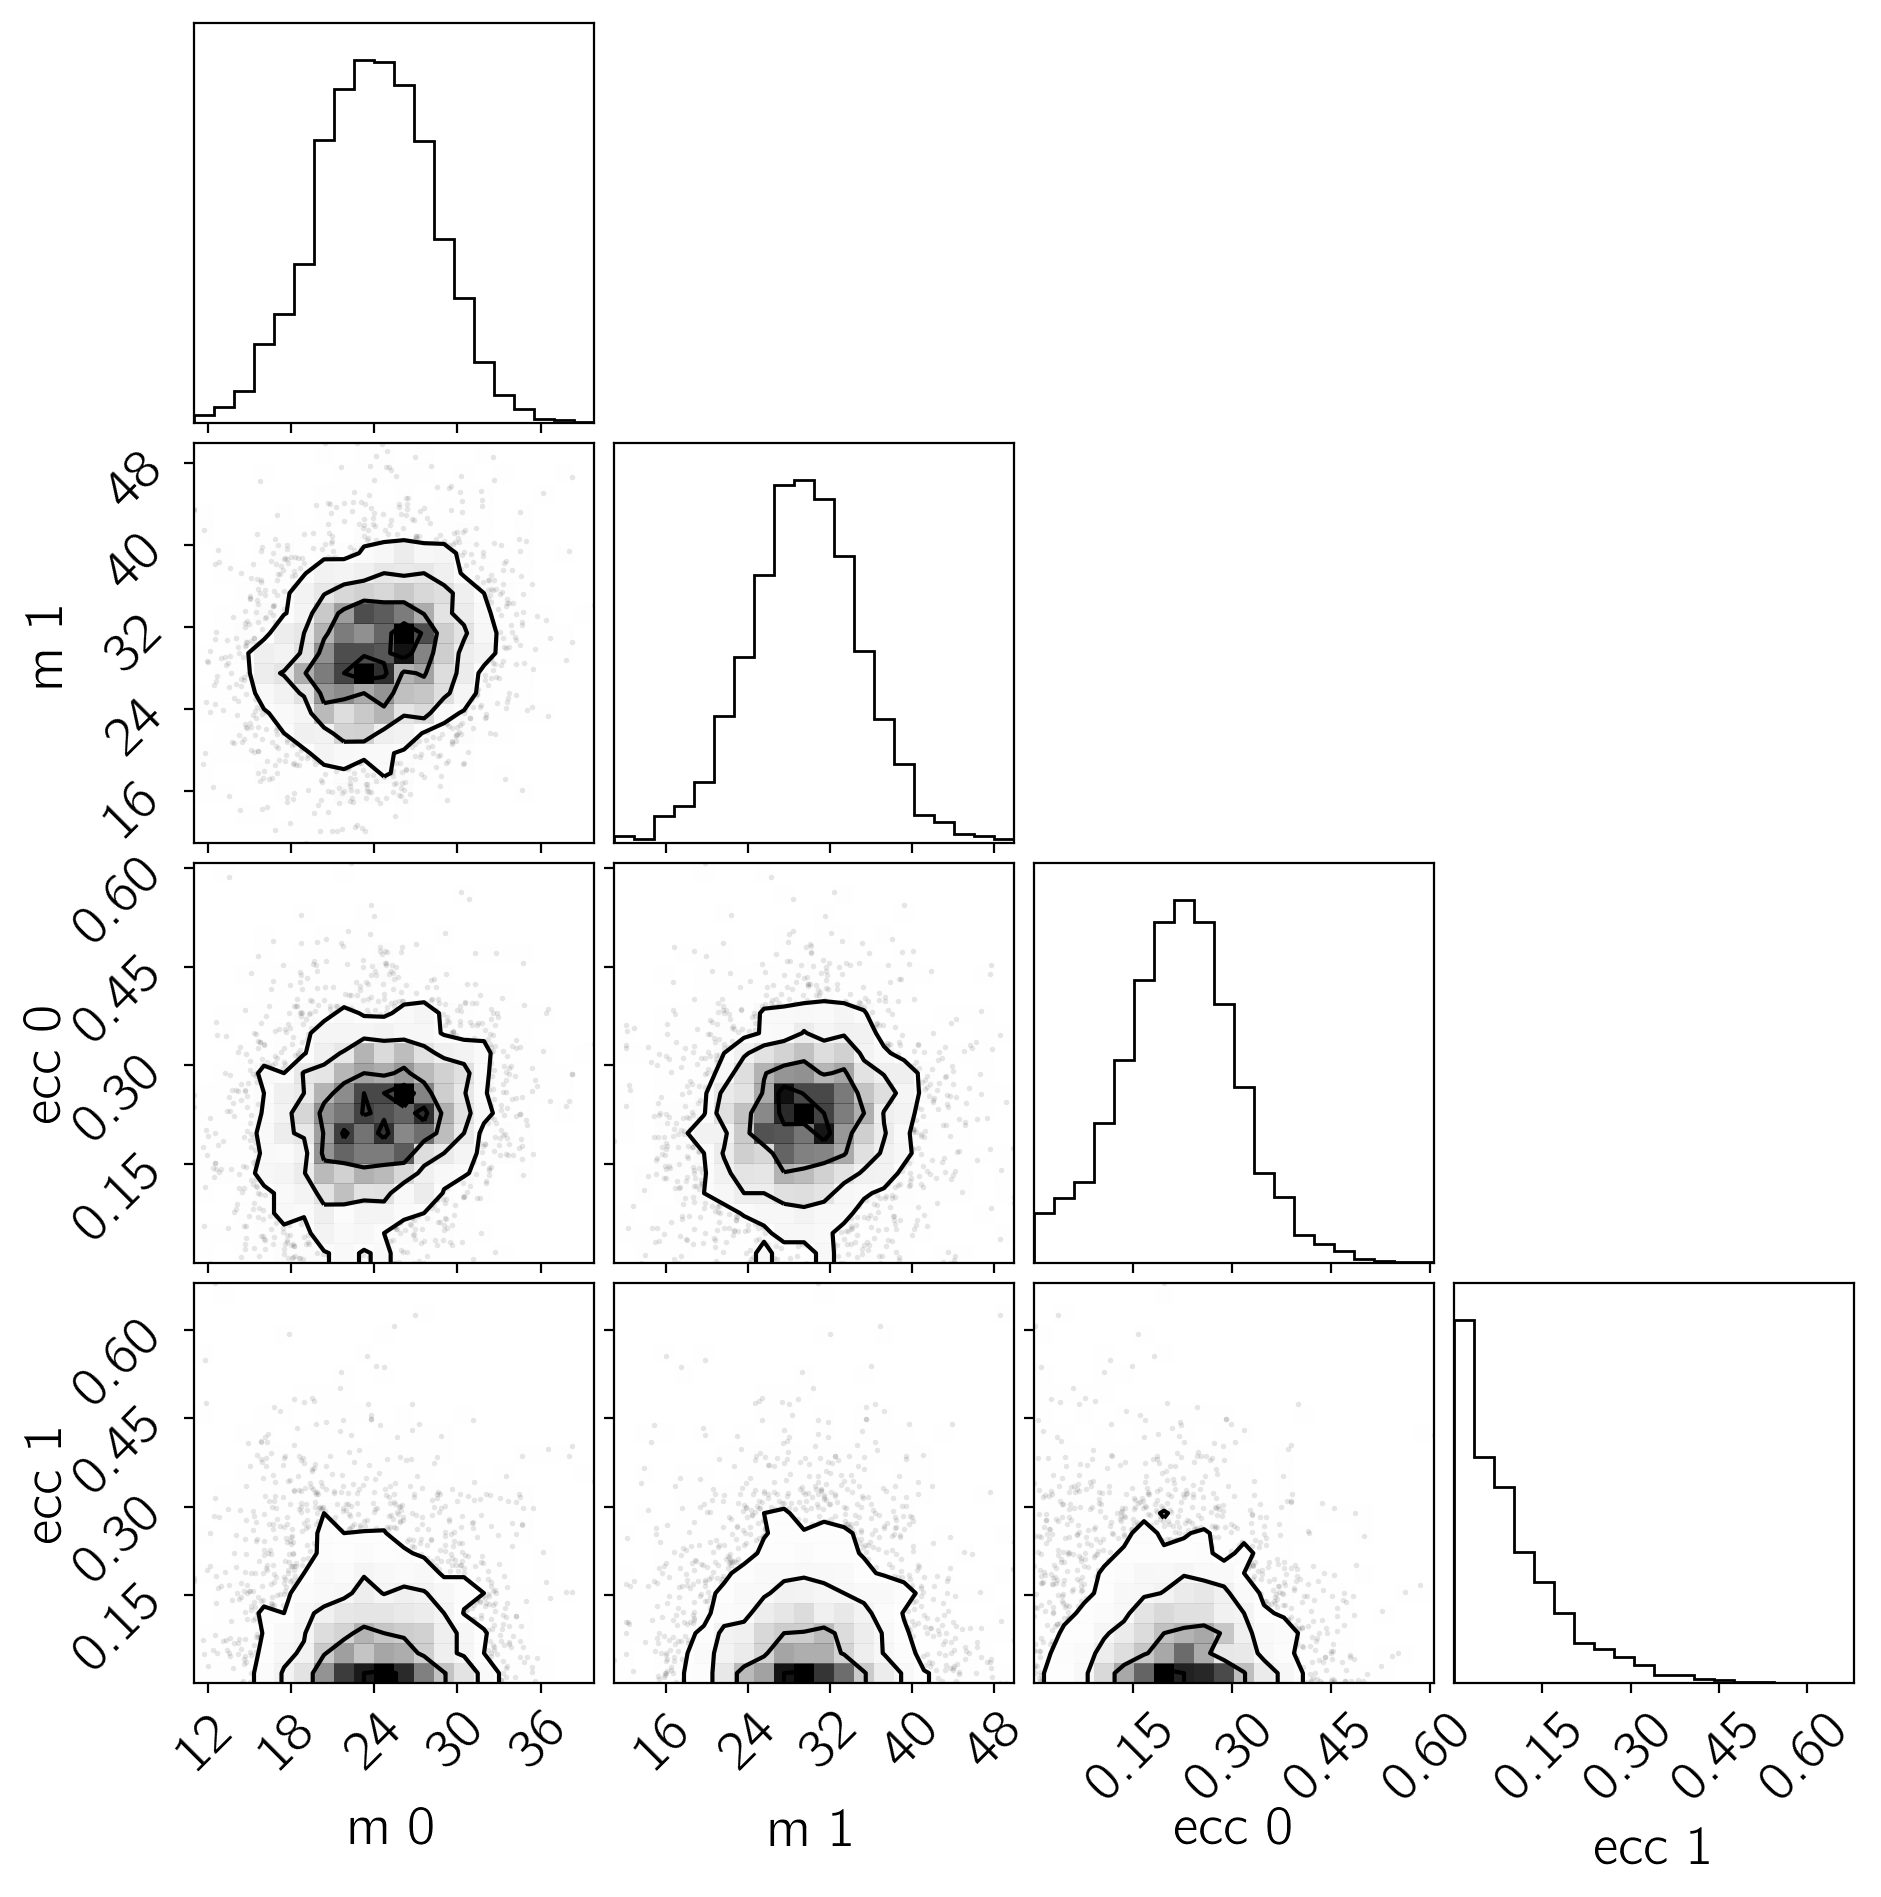

In [84]:
samples = pm.trace_to_dataframe(trace, varnames=["m", "ecc"])
samples.columns = [k.replace("_", " ") for k in samples.columns]
corner.corner(samples);

<ErrorbarContainer object of 3 artists>

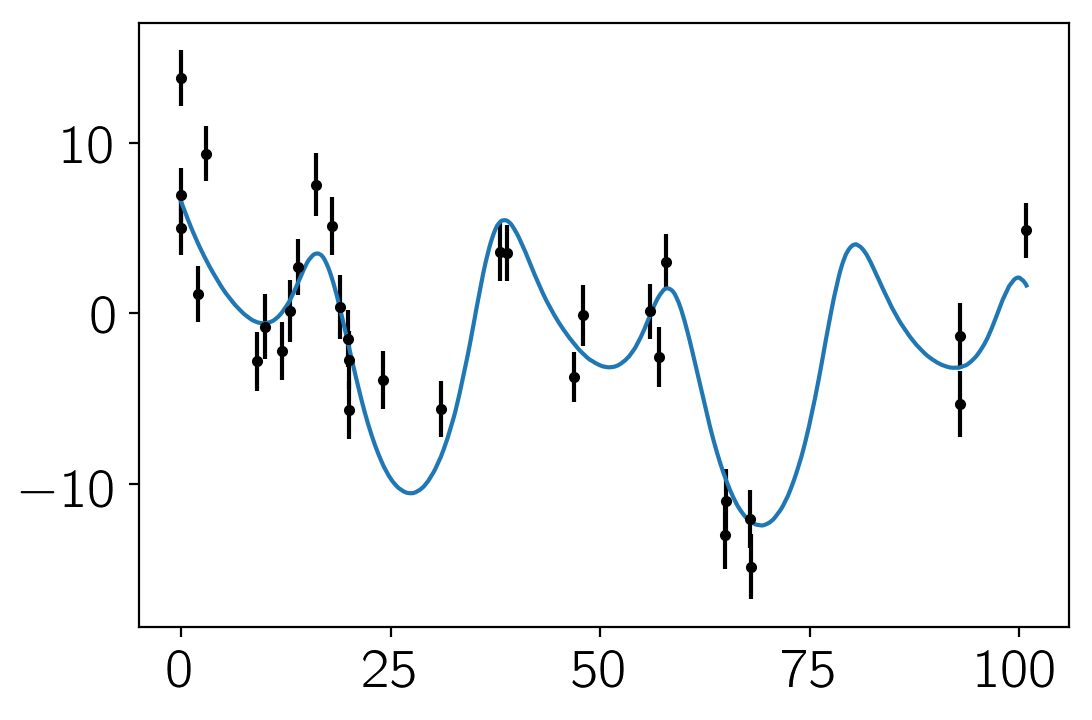

In [85]:
rvmodel = np.sum(trace["vrad"], axis=-1) + trace["bkg"]
plt.plot(x_grid, np.median(rvmodel, axis=0))
plt.errorbar(x, y, yerr=yerr, fmt=".k")